# Comprehensive Performance Benchmark: fftvis vs matvis

This notebook benchmarks the performance of fftvis (both CPU and GPU backends) against matvis across various parameter configurations to understand scaling behavior and speedup factors.

## Setup and Imports

In [1]:
# Standard imports
import numpy as np
import healpy as hp
from astropy.time import Time
import matplotlib.pyplot as plt
import time
import pandas as pd
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# System info imports
import platform
import psutil
import subprocess
import os
from datetime import datetime

# HERA-stack imports
import fftvis
import matvis
from hera_sim.antpos import hex_array
from pyuvdata.telescopes import Telescope
from pyuvdata.analytic_beam import AiryBeam

# Ray for multiprocessing
import ray
if ray.is_initialized():
    ray.shutdown()

# GPU imports
try:
    import cupy as cp
    from fftvis.gpu.nufft import HAVE_CUFINUFFT
    GPU_AVAILABLE = cp.cuda.is_available() and HAVE_CUFINUFFT
    if GPU_AVAILABLE:
        print(f"✅ GPU is available with {cp.cuda.runtime.getDeviceCount()} device(s)")
        # Get GPU memory info
        mempool = cp.get_default_memory_pool()
        device = cp.cuda.Device(0)
        total_memory = device.mem_info[1] / 1e9
        print(f"   Total GPU memory: {total_memory:.1f} GB")
    else:
        print("❌ GPU not available")
except ImportError:
    GPU_AVAILABLE = False
    print("❌ GPU dependencies not installed")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

✅ GPU is available with 1 device(s)
   Total GPU memory: 2.1 GB


In [2]:
# Collect system information
def get_system_info():
    """Collect system information for benchmark documentation."""
    info = {}
    
    # Basic system info
    info['platform'] = platform.platform()
    info['processor'] = platform.processor()
    info['python_version'] = platform.python_version()
    
    # CPU info
    info['cpu_count'] = psutil.cpu_count(logical=False)
    info['cpu_count_logical'] = psutil.cpu_count(logical=True)
    info['cpu_freq'] = psutil.cpu_freq().current if psutil.cpu_freq() else 'N/A'
    
    # Memory info
    mem = psutil.virtual_memory()
    info['ram_total_gb'] = round(mem.total / (1024**3), 2)
    info['ram_available_gb'] = round(mem.available / (1024**3), 2)
    
    # GPU info if available
    if GPU_AVAILABLE:
        info['gpu_count'] = cp.cuda.runtime.getDeviceCount()
        for i in range(info['gpu_count']):
            props = cp.cuda.runtime.getDeviceProperties(i)
            info[f'gpu_{i}_name'] = props['name'].decode('utf-8')
            info[f'gpu_{i}_memory_gb'] = round(props['totalGlobalMem'] / (1024**3), 2)
            info[f'gpu_{i}_compute_capability'] = f"{props['major']}.{props['minor']}"
    
    # Try to get CPU model name (Linux specific)
    try:
        cpu_info = subprocess.check_output("lscpu | grep 'Model name'", shell=True).decode()
        info['cpu_model'] = cpu_info.split(':')[1].strip()
    except:
        info['cpu_model'] = platform.processor()
    
    return info

# Get and display system info
system_info = get_system_info()
print("System Information:")
print("-" * 60)
for key, value in system_info.items():
    print(f"{key:25s}: {value}")
print("-" * 60)

System Information:
------------------------------------------------------------
platform                 : Linux-6.11.0-26-generic-x86_64-with-glibc2.39
processor                : x86_64
python_version           : 3.11.9
cpu_count                : 12
cpu_count_logical        : 24
cpu_freq                 : 2773.144875
ram_total_gb             : 94.18
ram_available_gb         : 74.3
gpu_count                : 1
gpu_0_name               : Quadro P600
gpu_0_memory_gb          : 1.94
gpu_0_compute_capability : 6.1
cpu_model                : AMD Ryzen 9 5900X 12-Core Processor
------------------------------------------------------------


## Define Base Configuration

In [3]:
# Base telescope configuration
def create_base_config(nants: int = 15) -> Dict:
    """Create base configuration for simulations."""
    
    # Antenna positions
    if nants <= 7:
        antpos = hex_array(2, split_core=True, outriggers=0)
    elif nants <= 15:
        antpos = hex_array(3, split_core=True, outriggers=0)
    elif nants <= 37:
        antpos = hex_array(4, split_core=True, outriggers=0)
    elif nants <= 61:
        antpos = hex_array(5, split_core=True, outriggers=0)
    elif nants <= 91:
        antpos = hex_array(6, split_core=True, outriggers=0)
    elif nants <= 127:
        antpos = hex_array(7, split_core=True, outriggers=0)
    else:
        antpos = hex_array(8, split_core=True, outriggers=0)
    
    # Select subset of antennas if needed
    if len(antpos) > nants:
        antpos = {i: antpos[i] for i in range(nants)}
    
    # Create beam - just use AiryBeam directly
    beam = AiryBeam(diameter=14.0)
    
    # Telescope location
    telescope_loc = Telescope.from_known_telescopes('hera').location
    
    # Baselines - create all baselines (including autocorrelations) to match matvis
    # matvis computes all i,j pairs where i and j go from 0 to nants-1
    baselines = [(i, j) for i in range(len(antpos)) for j in range(len(antpos))]
    
    return {
        'antpos': antpos,
        'beam': beam,
        'telescope_loc': telescope_loc,
        'baselines': baselines,
        'nants': len(antpos),
        'nbls': len(baselines)
    }

# Test base configuration
base_config = create_base_config()
print(f"Base configuration created with {base_config['nants']} antennas and {base_config['nbls']} baselines")

Base configuration created with 15 antennas and 225 baselines


## Define Sky Model Generator

In [4]:
def create_sky_model(nside: int, freqs: np.ndarray, seed: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Create a HEALPix-based sky model.
    
    Parameters
    ----------
    nside : int
        HEALPix nside parameter
    freqs : np.ndarray
        Frequency array in Hz
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    ra : np.ndarray
        Right ascension in radians
    dec : np.ndarray
        Declination in radians  
    flux_allfreq : np.ndarray
        Flux array with shape (nsources, nfreqs)
    """
    np.random.seed(seed)
    
    nsource = hp.nside2npix(nside)
    
    # Get HEALPix coordinates
    dec, ra = hp.pix2ang(nside, np.arange(nsource))
    dec -= np.pi / 2
    
    # Generate flux with power-law spectrum
    flux = np.random.uniform(0, 1, nsource)
    alpha = np.ones(nsource) * -0.8  # Spectral index
    
    # Calculate flux at all frequencies
    flux_allfreq = ((freqs[:, np.newaxis] / freqs[0]) ** alpha.T * flux.T).T
    
    return ra, dec, flux_allfreq

## Define GPU Memory Management Functions

In [5]:
def aggressive_gpu_cleanup():
    """Perform aggressive GPU memory cleanup to maximize available memory."""
    import gc
    
    if not GPU_AVAILABLE:
        return 0, 0
    
    # Synchronize all CUDA operations
    cp.cuda.runtime.deviceSynchronize()
    
    # Free all memory pools
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    
    # Clear all cached memory blocks
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    
    # Force Python garbage collection
    gc.collect()
    
    # Clear cache and force deallocation
    cp.cuda.runtime.memGetInfo()
    
    # Additional synchronization
    cp.cuda.runtime.deviceSynchronize()
    
    # One more aggressive cleanup
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    
    # Get device memory info
    free_mem, total_mem = cp.cuda.runtime.memGetInfo()
    
    return free_mem / 1e9, total_mem / 1e9

# Test the cleanup function
if GPU_AVAILABLE:
    free_gb, total_gb = aggressive_gpu_cleanup()
    print(f"GPU memory after cleanup: {free_gb:.2f}/{total_gb:.2f} GB free")

GPU memory after cleanup: 0.70/2.08 GB free


## Define Benchmark Function

In [6]:
def benchmark_single_config(
    config: Dict,
    nside: int,
    ntimes: int,
    nfreqs: int,
    backends: List[str] = ['matvis', 'fftvis_cpu', 'fftvis_gpu'],
    n_runs: int = 3,
    precision: int = 2,
    check_consistency: bool = True,
    eps: float = 1e-10
) -> Dict[str, float]:
    """Benchmark a single configuration across different backends.
    
    Parameters
    ----------
    config : Dict
        Base telescope configuration
    nside : int
        HEALPix nside for sky model
    ntimes : int
        Number of time samples
    nfreqs : int
        Number of frequency channels
    backends : List[str]
        List of backends to benchmark
    n_runs : int
        Number of runs for timing (best of n_runs)
    precision : int
        Precision setting (1 for float32, 2 for float64)
    check_consistency : bool
        Whether to check that all backends produce the same results
    eps : float
        Precision parameter for NUFFT
        
    Returns
    -------
    results : Dict[str, float]
        Timing results for each backend
    """
    # Create observation parameters
    freqs = np.linspace(100e6, 120e6, nfreqs)
    times = Time(np.linspace(2459845, 2459845 + 0.1 * ntimes / 288, ntimes), format='jd', scale='utc')
    
    # Create sky model
    ra, dec, flux_allfreq = create_sky_model(nside, freqs)
    nsources = len(ra)
    
    results = {
        'nside': nside,
        'nsources': nsources,
        'ntimes': ntimes,
        'nfreqs': nfreqs,
        'nants': config['nants'],
        'nbls': config['nbls']
    }
    
    # Store visibilities for comparison
    vis_results = {}
    
    # Benchmark matvis
    if 'matvis' in backends:
        print(f"  Benchmarking matvis...")
        times_matvis = []
        for _ in range(n_runs):
            t0 = time.perf_counter()
            vis_matvis = matvis.simulate_vis(
                ants=config['antpos'],
                fluxes=flux_allfreq,
                ra=ra,
                dec=dec,
                freqs=freqs,
                times=times,
                telescope_loc=config['telescope_loc'],
                beams=[config['beam']],
                polarized=False,
                precision=precision,
            )
            times_matvis.append(time.perf_counter() - t0)
        results['matvis'] = min(times_matvis)
        vis_results['matvis'] = vis_matvis
        print(f" {results['matvis']:.2f}s")
    
    # Benchmark fftvis CPU
    if 'fftvis_cpu' in backends:
        print(f"  Benchmarking fftvis CPU...")
        times_cpu = []
        for _ in range(n_runs):
            t0 = time.perf_counter()
            vis_cpu = fftvis.simulate_vis(
                ants=config['antpos'],
                fluxes=flux_allfreq,
                ra=ra,
                dec=dec,
                freqs=freqs,
                times=times.jd,
                telescope_loc=config['telescope_loc'],
                beam=config['beam'],
                polarized=False,
                precision=precision,
                eps=eps,
                nprocesses=1,
                baselines=config['baselines'],
                backend="cpu"
            )
            times_cpu.append(time.perf_counter() - t0)
        results['fftvis_cpu'] = min(times_cpu)
        vis_results['fftvis_cpu'] = vis_cpu
        print(f" {results['fftvis_cpu']:.2f}s")
    
    # Benchmark fftvis GPU with aggressive cleanup
    if 'fftvis_gpu' in backends and GPU_AVAILABLE:
        print(f"  Benchmarking fftvis GPU...")
        
        # Perform aggressive cleanup before starting
        free_gb, total_gb = aggressive_gpu_cleanup()
        print(f"    GPU memory: {free_gb:.2f}/{total_gb:.2f} GB free")
        
        times_gpu = []
        for _ in range(n_runs):
            try:
                t0 = time.perf_counter()
                vis_gpu = fftvis.simulate_vis(
                    ants=config['antpos'],
                    fluxes=flux_allfreq,
                    ra=ra,
                    dec=dec,
                    freqs=freqs,
                    times=times.jd,
                    telescope_loc=config['telescope_loc'],
                    beam=config['beam'],
                    polarized=False,
                    precision=precision,
                    eps=eps,
                    nprocesses=1,
                    baselines=config['baselines'],
                    backend="gpu"
                )
                times_gpu.append(time.perf_counter() - t0)
                
                # Perform aggressive cleanup after each run
                free_gb, _ = aggressive_gpu_cleanup()
                
            except (ValueError, MemoryError, RuntimeError) as e:
                error_msg = str(e)
                if "Dataset too large for GPU memory" in error_msg or "GPU out of memory" in error_msg:
                    print(f"    GPU memory exceeded at {nsources:,} sources")
                    results['fftvis_gpu'] = np.nan
                    break
                elif "GPU out of memory - cannot process" in error_msg:
                    print(f"    Critical GPU memory error - dataset too large")
                    results['fftvis_gpu'] = np.nan
                    break
                else:
                    raise
        
        if times_gpu:
            results['fftvis_gpu'] = min(times_gpu)
            vis_results['fftvis_gpu'] = vis_gpu
            print(f" {results['fftvis_gpu']:.2f}s")
    elif 'fftvis_gpu' in backends:
        results['fftvis_gpu'] = np.nan
        print(" GPU not available")
    
    # Check consistency between backends
    if check_consistency and len(vis_results) > 1:
        print("Checking consistency:\n", end='', flush=True)
        backends_list = list(vis_results.keys())
        all_match = True
        
        for i in range(len(backends_list)-1):
            for j in range(i+1, len(backends_list)):
                b1, b2 = backends_list[i], backends_list[j]
                match = np.allclose(vis_results[b1], vis_results[b2], rtol=1e-5, atol=1e-8)
                if not match:
                    all_match = False
                    print(f" ✗ {b1} vs {b2}", end='')
                    # Check with looser tolerance
                    if np.allclose(vis_results[b1], vis_results[b2], rtol=1e-3, atol=1e-6):
                        print(" (matches with rtol=1e-3)", end='')
        
        if all_match:
            print(" ✓ All match!")
        else:
            print()  # New line after errors
    
    return results

## Benchmark 1: Scaling with Number of Sources

In [7]:
# Fixed parameters
FIXED_NTIMES = 10
FIXED_NFREQS = 10
FIXED_NANTS = 15

# Variable parameter - extended range with more tiers
# Note: Adjusted for Quadro P600 GPU memory limitations
nsides = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]

print("Benchmarking scaling with number of sources...\n")
print(f"Fixed: ntimes={FIXED_NTIMES}, nfreqs={FIXED_NFREQS}, nants={FIXED_NANTS}")
print("-" * 60)

source_scaling_results = []
config = create_base_config(FIXED_NANTS)

for nside in nsides:
    nsources = hp.nside2npix(nside)
    print(f"\nnside={nside} ({nsources:,} sources):")
    
    # For very large source counts, skip GPU if likely to fail
    backends = ['matvis', 'fftvis_cpu', 'fftvis_gpu']
    if nsources > 2_000_000 and GPU_AVAILABLE:
        # Check available memory
        free_gb, total_gb = aggressive_gpu_cleanup()
        if free_gb < 0.5:  # Less than 500MB free
            print(f"  Skipping GPU backend (only {free_gb:.2f} GB free)")
            backends = ['matvis', 'fftvis_cpu']
    
    result = benchmark_single_config(
        config=config,
        nside=nside,
        ntimes=FIXED_NTIMES,
        nfreqs=FIXED_NFREQS,
        n_runs=2,
        check_consistency=True,
        backends=backends
    )
    source_scaling_results.append(result)

# Convert to DataFrame for easier analysis
df_sources = pd.DataFrame(source_scaling_results)
df_sources['fftvis_cpu_speedup'] = df_sources['matvis'] / df_sources['fftvis_cpu']
if GPU_AVAILABLE:
    df_sources['fftvis_gpu_speedup'] = df_sources['matvis'] / df_sources['fftvis_gpu']
    df_sources['gpu_vs_cpu'] = df_sources['fftvis_cpu'] / df_sources['fftvis_gpu']

Benchmarking scaling with number of sources...

Fixed: ntimes=10, nfreqs=10, nants=15
------------------------------------------------------------

nside=8 (768 sources):
  Benchmarking matvis...
 0.31s
  Benchmarking fftvis CPU...
 1.30s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.40s
Checking consistency:
 ✓ All match!

nside=16 (3,072 sources):
  Benchmarking matvis...
 0.46s
  Benchmarking fftvis CPU...
 1.10s
  Benchmarking fftvis GPU...
    GPU memory: 0.68/2.08 GB free
 0.38s
Checking consistency:
 ✓ All match!

nside=32 (12,288 sources):
  Benchmarking matvis...
 1.49s
  Benchmarking fftvis CPU...
 1.21s
  Benchmarking fftvis GPU...
    GPU memory: 0.67/2.08 GB free
 0.41s
Checking consistency:
 ✓ All match!

nside=64 (49,152 sources):
  Benchmarking matvis...
 5.15s
  Benchmarking fftvis CPU...
 1.41s
  Benchmarking fftvis GPU...
    GPU memory: 0.68/2.08 GB free
 0.67s
Checking consistency:
 ✓ All match!

nside=96 (110,592 sources):
  Benchmarking matvis

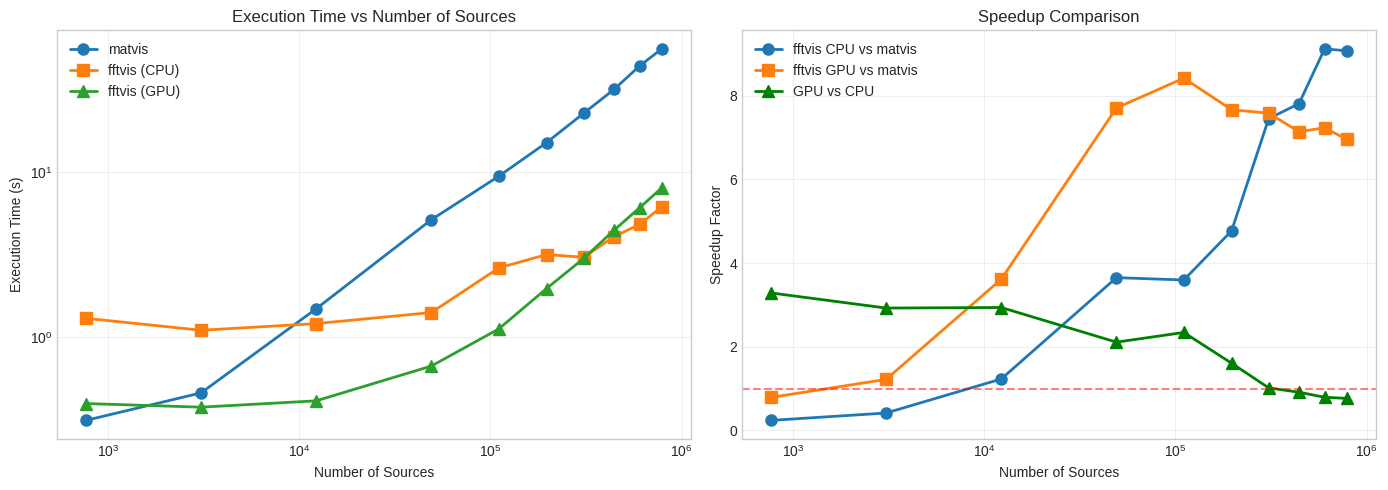


Source Scaling Summary:


,nsources,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup,gpu_vs_cpu
0,768,0.31,1.30,0.40,0.24,0.79,3.29
1,3072,0.46,1.10,0.38,0.42,1.22,2.92
2,12288,1.49,1.21,0.41,1.23,3.61,2.94
3,49152,5.15,1.41,0.67,3.65,7.70,2.11
4,110592,9.44,2.63,1.12,3.59,8.42,2.34
5,196608,15.11,3.17,1.97,4.77,7.66,1.61
6,307200,22.73,3.05,3.00,7.45,7.58,1.02
7,442368,31.69,4.06,4.44,7.81,7.13,0.91
8,602112,43.99,4.83,6.08,9.11,7.23,0.79
9,786432,55.83,6.16,8.03,9.07,6.95,0.77


In [8]:
# Plot source scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot
ax1.loglog(df_sources['nsources'], df_sources['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.loglog(df_sources['nsources'], df_sources['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.loglog(df_sources['nsources'], df_sources['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Sources')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Sources')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot
ax2.semilogx(df_sources['nsources'], df_sources['fftvis_cpu_speedup'], 'o-', 
             label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.semilogx(df_sources['nsources'], df_sources['fftvis_gpu_speedup'], 's-', 
                 label='fftvis GPU vs matvis', linewidth=2, markersize=8)
    ax2.semilogx(df_sources['nsources'], df_sources['gpu_vs_cpu'], '^-', 
                 label='GPU vs CPU', linewidth=2, markersize=8, color='green')

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Sources')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nSource Scaling Summary:")
display(df_sources[['nsources', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                    'fftvis_cpu_speedup', 'fftvis_gpu_speedup', 'gpu_vs_cpu']].round(2))

## Benchmark 2: Scaling with Number of Times

In [9]:
# Fixed parameters
FIXED_NSIDE = 32  # ~12k sources
FIXED_NFREQS = 10
FIXED_NANTS = 15

# Variable parameter - extended range
ntimes_list = [5, 10, 20, 40, 80, 120, 160, 200, 240]

print("Benchmarking scaling with number of times...\n")
print(f"Fixed: nside={FIXED_NSIDE} ({hp.nside2npix(FIXED_NSIDE):,} sources), nfreqs={FIXED_NFREQS}, nants={FIXED_NANTS}")
print("-" * 60)

time_scaling_results = []
config = create_base_config(FIXED_NANTS)

for ntimes in ntimes_list:
    print(f"\nntimes={ntimes}:")
    
    result = benchmark_single_config(
        config=config,
        nside=FIXED_NSIDE,
        ntimes=ntimes,
        nfreqs=FIXED_NFREQS,
        n_runs=2,
        check_consistency=True
    )
    time_scaling_results.append(result)

# Convert to DataFrame
df_times = pd.DataFrame(time_scaling_results)
df_times['fftvis_cpu_speedup'] = df_times['matvis'] / df_times['fftvis_cpu']
if GPU_AVAILABLE:
    df_times['fftvis_gpu_speedup'] = df_times['matvis'] / df_times['fftvis_gpu']
    df_times['gpu_vs_cpu'] = df_times['fftvis_cpu'] / df_times['fftvis_gpu']

Benchmarking scaling with number of times...

Fixed: nside=32 (12,288 sources), nfreqs=10, nants=15
------------------------------------------------------------

ntimes=5:
  Benchmarking matvis...
 0.73s
  Benchmarking fftvis CPU...
 0.59s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.22s
Checking consistency:
 ✓ All match!

ntimes=10:
  Benchmarking matvis...
 1.07s
  Benchmarking fftvis CPU...
 1.24s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.41s
Checking consistency:
 ✓ All match!

ntimes=20:
  Benchmarking matvis...
 2.87s
  Benchmarking fftvis CPU...
 2.66s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.81s
Checking consistency:
 ✓ All match!

ntimes=40:
  Benchmarking matvis...
 4.24s
  Benchmarking fftvis CPU...
 4.75s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 1.62s
Checking consistency:
 ✓ All match!

ntimes=80:
  Benchmarking matvis...
 8.43s
  Benchmarking fftvis CPU...
 9.92s
  Benchmarking f

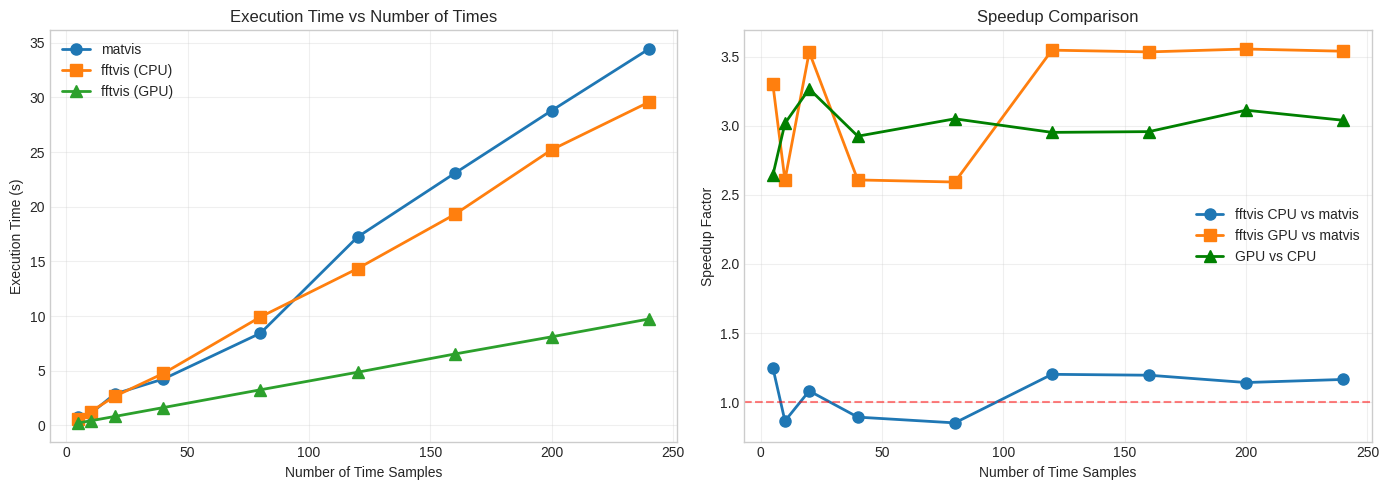


Time Scaling Summary:


,ntimes,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup,gpu_vs_cpu
0,5,0.73,0.59,0.22,1.25,3.30,2.64
1,10,1.07,1.24,0.41,0.86,2.61,3.02
2,20,2.87,2.66,0.81,1.08,3.53,3.27
3,40,4.24,4.75,1.62,0.89,2.61,2.93
4,80,8.43,9.92,3.25,0.85,2.59,3.05
5,120,17.23,14.34,4.86,1.20,3.55,2.95
6,160,23.06,19.30,6.52,1.20,3.54,2.96
7,200,28.81,25.22,8.10,1.14,3.56,3.11
8,240,34.44,29.57,9.73,1.16,3.54,3.04


In [10]:
# Plot time scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot
ax1.plot(df_times['ntimes'], df_times['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.plot(df_times['ntimes'], df_times['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.plot(df_times['ntimes'], df_times['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Time Samples')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Times')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot
ax2.plot(df_times['ntimes'], df_times['fftvis_cpu_speedup'], 'o-', 
         label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.plot(df_times['ntimes'], df_times['fftvis_gpu_speedup'], 's-', 
             label='fftvis GPU vs matvis', linewidth=2, markersize=8)
    ax2.plot(df_times['ntimes'], df_times['gpu_vs_cpu'], '^-', 
             label='GPU vs CPU', linewidth=2, markersize=8, color='green')

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Time Samples')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nTime Scaling Summary:")
display(df_times[['ntimes', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                  'fftvis_cpu_speedup', 'fftvis_gpu_speedup', 'gpu_vs_cpu']].round(2))

## Benchmark 3: Scaling with Number of Frequencies

In [11]:
# Fixed parameters
FIXED_NSIDE = 32  # ~12k sources
FIXED_NTIMES = 10
FIXED_NANTS = 15

# Variable parameter - extended range
nfreqs_list = [5, 10, 20, 40, 80, 120, 160, 200, 240]

print("Benchmarking scaling with number of frequencies...\n")
print(f"Fixed: nside={FIXED_NSIDE} ({hp.nside2npix(FIXED_NSIDE):,} sources), ntimes={FIXED_NTIMES}, nants={FIXED_NANTS}")
print("-" * 60)

freq_scaling_results = []
config = create_base_config(FIXED_NANTS)

for nfreqs in nfreqs_list:
    print(f"\nnfreqs={nfreqs}:")
    
    result = benchmark_single_config(
        config=config,
        nside=FIXED_NSIDE,
        ntimes=FIXED_NTIMES,
        nfreqs=nfreqs,
        n_runs=2,
        check_consistency=True
    )
    freq_scaling_results.append(result)

# Convert to DataFrame
df_freqs = pd.DataFrame(freq_scaling_results)
df_freqs['fftvis_cpu_speedup'] = df_freqs['matvis'] / df_freqs['fftvis_cpu']
if GPU_AVAILABLE:
    df_freqs['fftvis_gpu_speedup'] = df_freqs['matvis'] / df_freqs['fftvis_gpu']
    df_freqs['gpu_vs_cpu'] = df_freqs['fftvis_cpu'] / df_freqs['fftvis_gpu']

Benchmarking scaling with number of frequencies...

Fixed: nside=32 (12,288 sources), ntimes=10, nants=15
------------------------------------------------------------

nfreqs=5:
  Benchmarking matvis...
 0.54s
  Benchmarking fftvis CPU...
 0.53s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.23s
Checking consistency:
 ✓ All match!

nfreqs=10:
  Benchmarking matvis...
 1.06s
  Benchmarking fftvis CPU...
 1.16s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.41s
Checking consistency:
 ✓ All match!

nfreqs=20:
  Benchmarking matvis...
 2.88s
  Benchmarking fftvis CPU...
 2.23s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.78s
Checking consistency:
 ✓ All match!

nfreqs=40:
  Benchmarking matvis...
 5.78s
  Benchmarking fftvis CPU...
 4.76s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 1.55s
Checking consistency:
 ✓ All match!

nfreqs=80:
  Benchmarking matvis...
 8.51s
  Benchmarking fftvis CPU...
 8.91s
  Benchmar

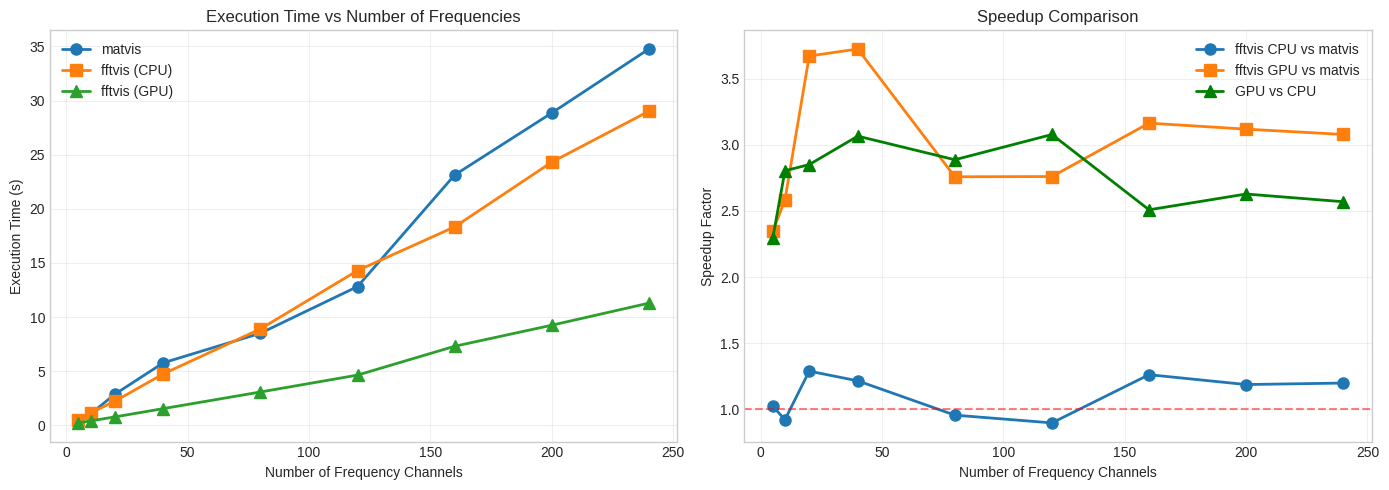


Frequency Scaling Summary:


,nfreqs,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup,gpu_vs_cpu
0,5,0.54,0.53,0.23,1.02,2.35,2.30
1,10,1.06,1.16,0.41,0.92,2.58,2.80
2,20,2.88,2.23,0.78,1.29,3.67,2.85
3,40,5.78,4.76,1.55,1.21,3.72,3.07
4,80,8.51,8.91,3.09,0.96,2.76,2.89
5,120,12.83,14.30,4.65,0.90,2.76,3.08
6,160,23.13,18.33,7.31,1.26,3.16,2.51
7,200,28.85,24.31,9.25,1.19,3.12,2.63
8,240,34.76,29.01,11.29,1.20,3.08,2.57


In [12]:
# Plot frequency scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot
ax1.plot(df_freqs['nfreqs'], df_freqs['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Frequency Channels')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Frequencies')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot
ax2.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu_speedup'], 'o-', 
         label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu_speedup'], 's-', 
             label='fftvis GPU vs matvis', linewidth=2, markersize=8)
    ax2.plot(df_freqs['nfreqs'], df_freqs['gpu_vs_cpu'], '^-', 
             label='GPU vs CPU', linewidth=2, markersize=8, color='green')

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Frequency Channels')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nFrequency Scaling Summary:")
display(df_freqs[['nfreqs', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                  'fftvis_cpu_speedup', 'fftvis_gpu_speedup', 'gpu_vs_cpu']].round(2))

## Benchmark 4: Scaling with Number of Antennas/Baselines

In [13]:
# Fixed parameters
FIXED_NSIDE = 32  # ~12k sources
FIXED_NTIMES = 10
FIXED_NFREQS = 10

# Variable parameter - extended range
nants_list = [7, 15, 25, 37, 50, 61, 75, 91, 110]

print("Benchmarking scaling with number of antennas...\n")
print(f"Fixed: nside={FIXED_NSIDE} ({hp.nside2npix(FIXED_NSIDE):,} sources), ntimes={FIXED_NTIMES}, nfreqs={FIXED_NFREQS}")
print("-" * 60)

ant_scaling_results = []

for nants in nants_list:
    config = create_base_config(nants)
    print(f"\nnants={nants} ({config['nbls']} baselines):")
    
    result = benchmark_single_config(
        config=config,
        nside=FIXED_NSIDE,
        ntimes=FIXED_NTIMES,
        nfreqs=FIXED_NFREQS,
        n_runs=2,
        check_consistency=True
    )
    ant_scaling_results.append(result)

# Convert to DataFrame
df_ants = pd.DataFrame(ant_scaling_results)
df_ants['fftvis_cpu_speedup'] = df_ants['matvis'] / df_ants['fftvis_cpu']
if GPU_AVAILABLE:
    df_ants['fftvis_gpu_speedup'] = df_ants['matvis'] / df_ants['fftvis_gpu']
    df_ants['gpu_vs_cpu'] = df_ants['fftvis_cpu'] / df_ants['fftvis_gpu']

Benchmarking scaling with number of antennas...

Fixed: nside=32 (12,288 sources), ntimes=10, nfreqs=10
------------------------------------------------------------

nants=7 (25 baselines):
  Benchmarking matvis...
 0.76s
  Benchmarking fftvis CPU...
 1.16s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.36s
Checking consistency:
 ✓ All match!

nants=15 (225 baselines):
  Benchmarking matvis...
 1.06s
  Benchmarking fftvis CPU...
 1.11s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.41s
Checking consistency:
 ✓ All match!

nants=25 (625 baselines):
  Benchmarking matvis...
 1.87s
  Benchmarking fftvis CPU...
 1.19s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.50s
Checking consistency:
 ✓ All match!

nants=37 (1089 baselines):
  Benchmarking matvis...
 2.28s
  Benchmarking fftvis CPU...
 1.10s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 0.54s
Checking consistency:
 ✓ All match!

nants=50 (2500 baselines):
  Be

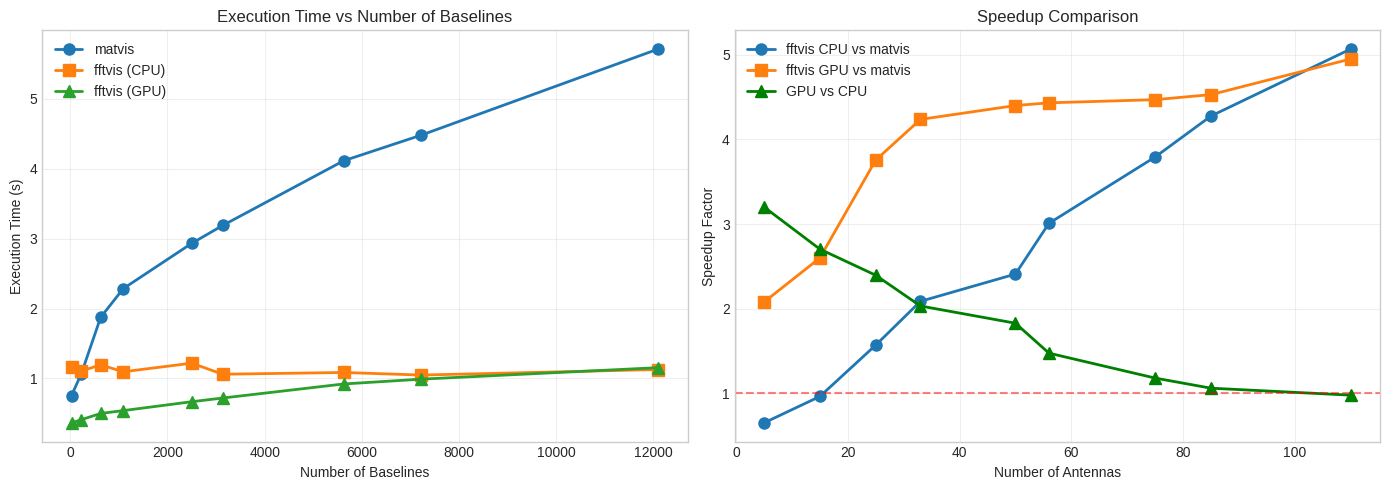


Antenna/Baseline Scaling Summary:


,nants,nbls,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup,gpu_vs_cpu
0,5,25,0.76,1.16,0.36,0.65,2.08,3.20
1,15,225,1.06,1.11,0.41,0.96,2.60,2.70
2,25,625,1.87,1.19,0.50,1.57,3.76,2.39
3,33,1089,2.28,1.10,0.54,2.09,4.24,2.03
4,50,2500,2.93,1.22,0.67,2.41,4.40,1.83
5,56,3136,3.19,1.06,0.72,3.01,4.43,1.47
6,75,5625,4.11,1.08,0.92,3.79,4.47,1.18
7,85,7225,4.48,1.05,0.99,4.28,4.53,1.06
8,110,12100,5.71,1.13,1.15,5.07,4.95,0.98


In [14]:
# Plot antenna/baseline scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot vs baselines
ax1.plot(df_ants['nbls'], df_ants['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.plot(df_ants['nbls'], df_ants['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.plot(df_ants['nbls'], df_ants['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Baselines')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Baselines')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot vs antennas
ax2.plot(df_ants['nants'], df_ants['fftvis_cpu_speedup'], 'o-', 
         label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.plot(df_ants['nants'], df_ants['fftvis_gpu_speedup'], 's-', 
             label='fftvis GPU vs matvis', linewidth=2, markersize=8)
    ax2.plot(df_ants['nants'], df_ants['gpu_vs_cpu'], '^-', 
             label='GPU vs CPU', linewidth=2, markersize=8, color='green')

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Antennas')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nAntenna/Baseline Scaling Summary:")
display(df_ants[['nants', 'nbls', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                 'fftvis_cpu_speedup', 'fftvis_gpu_speedup', 'gpu_vs_cpu']].round(2))

## Comprehensive Scaling Analysis

In [15]:
# Large-scale benchmark configurations
print("\n" + "="*60)
print("LARGE-SCALE BENCHMARK CONFIGURATIONS")
print("="*60)

# Test a few large configurations
large_configs = [
    {'nside': 64, 'ntimes': 50, 'nfreqs': 50, 'nants': 37},
    {'nside': 96, 'ntimes': 30, 'nfreqs': 30, 'nants': 25},
    {'nside': 128, 'ntimes': 20, 'nfreqs': 20, 'nants': 15},
]

large_results = []

for i, cfg in enumerate(large_configs):
    print(f"\nLarge Config {i+1}:")
    print(f"  Sources: {hp.nside2npix(cfg['nside']):,} (nside={cfg['nside']})")
    print(f"  Times: {cfg['ntimes']}, Frequencies: {cfg['nfreqs']}, Antennas: {cfg['nants']}")
    
    config = create_base_config(cfg['nants'])
    print(f"  Baselines: {config['nbls']}")
    
    result = benchmark_single_config(
        config=config,
        nside=cfg['nside'],
        ntimes=cfg['ntimes'],
        nfreqs=cfg['nfreqs'],
        n_runs=1,  # Just one run for large configs
        check_consistency=True
    )
    
    # Add configuration details to result
    result.update(cfg)
    large_results.append(result)
    
    # Print speedup summary
    if 'fftvis_cpu' in result and 'matvis' in result:
        print(f"  Speedup (CPU): {result['matvis']/result['fftvis_cpu']:.2f}x")
    if GPU_AVAILABLE and 'fftvis_gpu' in result and 'matvis' in result:
        print(f"  Speedup (GPU): {result['matvis']/result['fftvis_gpu']:.2f}x")

# Convert to DataFrame
df_large = pd.DataFrame(large_results)
print("\n\nLarge Configuration Summary:")
display(df_large[['nsources', 'ntimes', 'nfreqs', 'nants', 'nbls', 
                  'matvis', 'fftvis_cpu', 'fftvis_gpu']].round(2))


LARGE-SCALE BENCHMARK CONFIGURATIONS

Large Config 1:
  Sources: 49,152 (nside=64)
  Times: 50, Frequencies: 50, Antennas: 37
  Baselines: 1089
  Benchmarking matvis...
 188.11s
  Benchmarking fftvis CPU...
 34.72s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 20.76s
Checking consistency:
 ✓ All match!
  Speedup (CPU): 5.42x
  Speedup (GPU): 9.06x

Large Config 2:
  Sources: 110,592 (nside=96)
  Times: 30, Frequencies: 30, Antennas: 25
  Baselines: 625
  Benchmarking matvis...
 107.06s
  Benchmarking fftvis CPU...
 17.56s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 11.11s
Checking consistency:
 ✓ All match!
  Speedup (CPU): 6.10x
  Speedup (GPU): 9.63x

Large Config 3:
  Sources: 196,608 (nside=128)
  Times: 20, Frequencies: 20, Antennas: 15
  Baselines: 225
  Benchmarking matvis...
 60.66s
  Benchmarking fftvis CPU...
 10.27s
  Benchmarking fftvis GPU...
    GPU memory: 0.70/2.08 GB free
 7.60s
Checking consistency:
 ✓ All match!
  Speedup (CPU):

,nsources,ntimes,nfreqs,nants,nbls,matvis,fftvis_cpu,fftvis_gpu
0,49152,50,50,37,1089,188.11,34.72,20.76
1,110592,30,30,25,625,107.06,17.56,11.11
2,196608,20,20,15,225,60.66,10.27,7.60


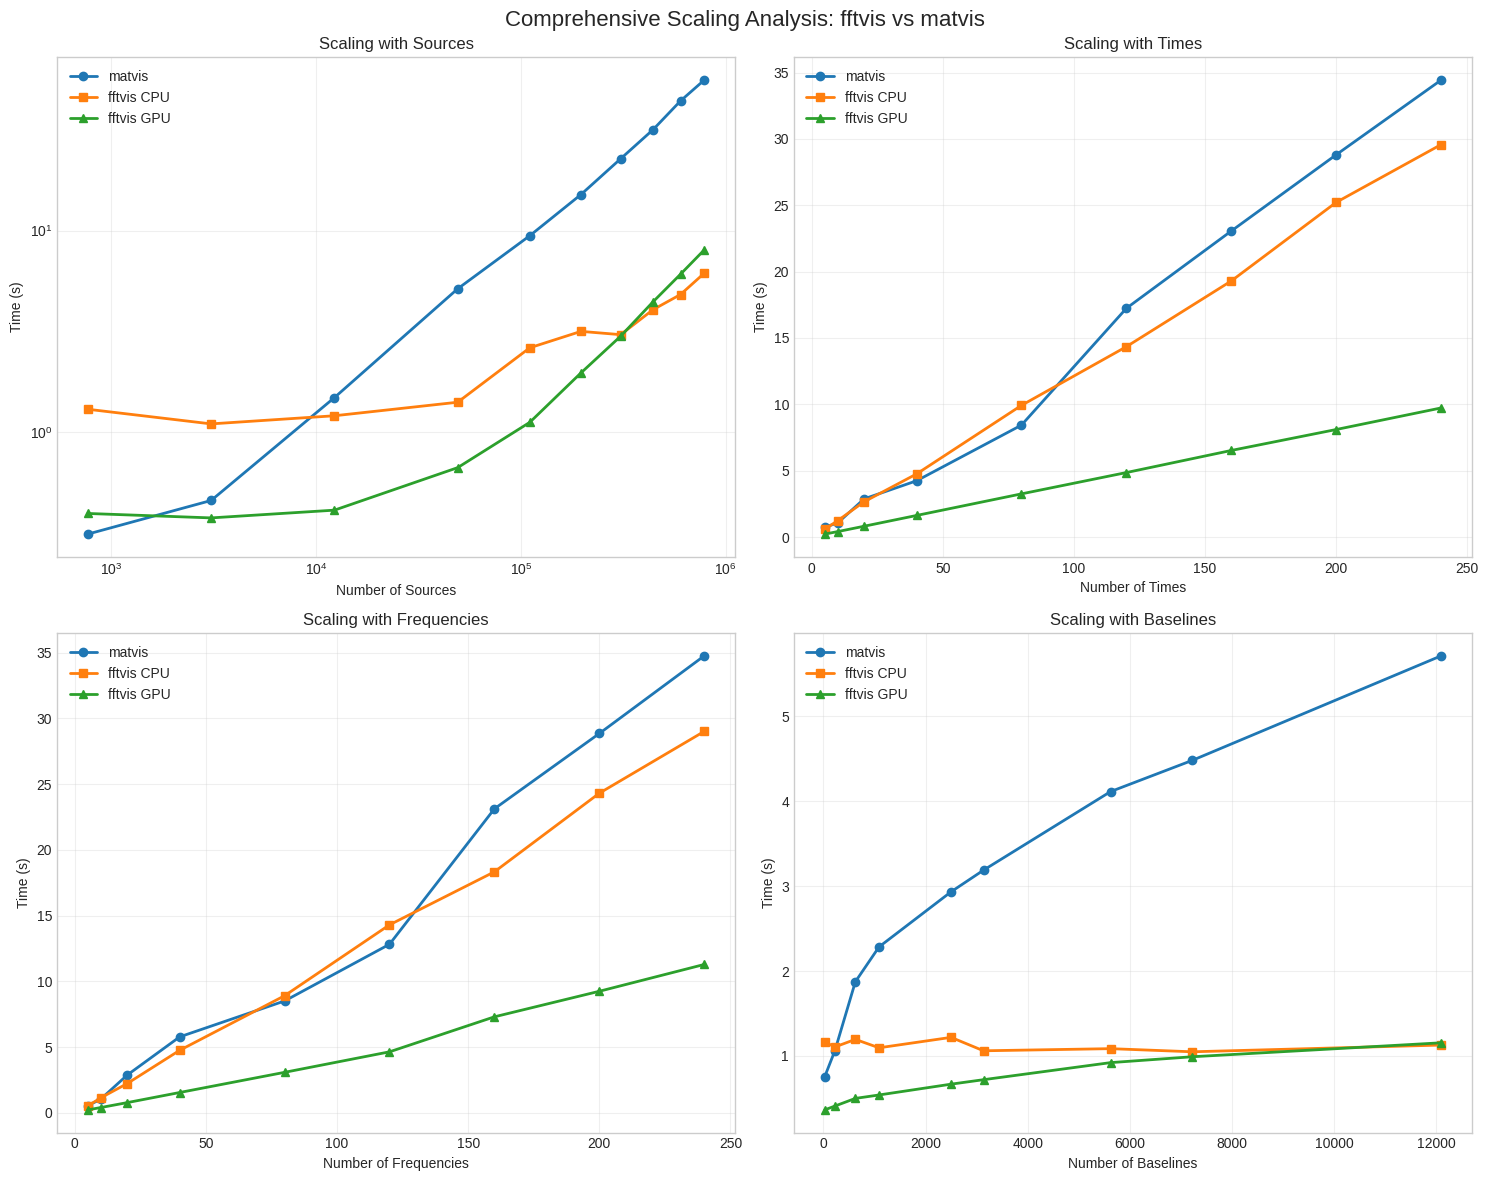

In [16]:
# Create a comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sources scaling
ax = axes[0, 0]
ax.loglog(df_sources['nsources'], df_sources['matvis'], 'o-', label='matvis', linewidth=2)
ax.loglog(df_sources['nsources'], df_sources['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.loglog(df_sources['nsources'], df_sources['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Sources')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Sources')
ax.legend()
ax.grid(True, alpha=0.3)

# Times scaling
ax = axes[0, 1]
ax.plot(df_times['ntimes'], df_times['matvis'], 'o-', label='matvis', linewidth=2)
ax.plot(df_times['ntimes'], df_times['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.plot(df_times['ntimes'], df_times['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Times')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequencies scaling
ax = axes[1, 0]
ax.plot(df_freqs['nfreqs'], df_freqs['matvis'], 'o-', label='matvis', linewidth=2)
ax.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Frequencies')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Frequencies')
ax.legend()
ax.grid(True, alpha=0.3)

# Baselines scaling
ax = axes[1, 1]
ax.plot(df_ants['nbls'], df_ants['matvis'], 'o-', label='matvis', linewidth=2)
ax.plot(df_ants['nbls'], df_ants['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.plot(df_ants['nbls'], df_ants['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Baselines')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Baselines')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Scaling Analysis: fftvis vs matvis', fontsize=16)
plt.tight_layout()
plt.show()

## Save Benchmark Results and Plots

In [17]:
# Create a directory for saving results
import os
from datetime import datetime

# Create output directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"benchmark_results_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

print(f"Saving results to: {output_dir}/")

# Save system information
with open(os.path.join(output_dir, "system_info.txt"), "w") as f:
    f.write("Benchmark System Information\n")
    f.write("=" * 60 + "\n")
    f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 60 + "\n\n")
    
    for key, value in system_info.items():
        f.write(f"{key:30s}: {value}\n")
    
    f.write("\n" + "=" * 60 + "\n")
    f.write("Software Versions:\n")
    f.write(f"fftvis version: {fftvis.__version__ if hasattr(fftvis, '__version__') else 'dev'}\n")
    f.write(f"matvis version: {matvis.__version__ if hasattr(matvis, '__version__') else 'dev'}\n")
    f.write(f"numpy version: {np.__version__}\n")
    if GPU_AVAILABLE:
        f.write(f"cupy version: {cp.__version__}\n")

# Function to recreate and save plots
def save_all_plots(output_dir):
    """Recreate and save all benchmark plots."""
    
    # 1. Source scaling plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.loglog(df_sources['nsources'], df_sources['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
    ax1.loglog(df_sources['nsources'], df_sources['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax1.loglog(df_sources['nsources'], df_sources['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title('Execution Time vs Number of Sources')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.semilogx(df_sources['nsources'], df_sources['fftvis_cpu_speedup'], 'o-', 
                 label='fftvis CPU vs matvis', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax2.semilogx(df_sources['nsources'], df_sources['fftvis_gpu_speedup'], 's-', 
                     label='fftvis GPU vs matvis', linewidth=2, markersize=8)
        ax2.semilogx(df_sources['nsources'], df_sources['gpu_vs_cpu'], '^-', 
                     label='GPU vs CPU', linewidth=2, markersize=8, color='green')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Number of Sources')
    ax2.set_ylabel('Speedup Factor')
    ax2.set_title('Speedup Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'source_scaling.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Time scaling plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(df_times['ntimes'], df_times['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
    ax1.plot(df_times['ntimes'], df_times['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax1.plot(df_times['ntimes'], df_times['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Time Samples')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title('Execution Time vs Number of Times')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(df_times['ntimes'], df_times['fftvis_cpu_speedup'], 'o-', 
             label='fftvis CPU vs matvis', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax2.plot(df_times['ntimes'], df_times['fftvis_gpu_speedup'], 's-', 
                 label='fftvis GPU vs matvis', linewidth=2, markersize=8)
        ax2.plot(df_times['ntimes'], df_times['gpu_vs_cpu'], '^-', 
                 label='GPU vs CPU', linewidth=2, markersize=8, color='green')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Number of Time Samples')
    ax2.set_ylabel('Speedup Factor')
    ax2.set_title('Speedup Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'time_scaling.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Frequency scaling plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(df_freqs['nfreqs'], df_freqs['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
    ax1.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax1.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Frequency Channels')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title('Execution Time vs Number of Frequencies')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu_speedup'], 'o-', 
             label='fftvis CPU vs matvis', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax2.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu_speedup'], 's-', 
                 label='fftvis GPU vs matvis', linewidth=2, markersize=8)
        ax2.plot(df_freqs['nfreqs'], df_freqs['gpu_vs_cpu'], '^-', 
                 label='GPU vs CPU', linewidth=2, markersize=8, color='green')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Number of Frequency Channels')
    ax2.set_ylabel('Speedup Factor')
    ax2.set_title('Speedup Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'frequency_scaling.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Antenna/baseline scaling plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(df_ants['nbls'], df_ants['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
    ax1.plot(df_ants['nbls'], df_ants['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax1.plot(df_ants['nbls'], df_ants['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Baselines')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title('Execution Time vs Number of Baselines')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(df_ants['nants'], df_ants['fftvis_cpu_speedup'], 'o-', 
             label='fftvis CPU vs matvis', linewidth=2, markersize=8)
    if GPU_AVAILABLE:
        ax2.plot(df_ants['nants'], df_ants['fftvis_gpu_speedup'], 's-', 
                 label='fftvis GPU vs matvis', linewidth=2, markersize=8)
        ax2.plot(df_ants['nants'], df_ants['gpu_vs_cpu'], '^-', 
                 label='GPU vs CPU', linewidth=2, markersize=8, color='green')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Number of Antennas')
    ax2.set_ylabel('Speedup Factor')
    ax2.set_title('Speedup Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'antenna_scaling.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Comprehensive scaling plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Sources scaling
    ax = axes[0, 0]
    ax.loglog(df_sources['nsources'], df_sources['matvis'], 'o-', label='matvis', linewidth=2)
    ax.loglog(df_sources['nsources'], df_sources['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
    if GPU_AVAILABLE:
        ax.loglog(df_sources['nsources'], df_sources['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
    ax.set_xlabel('Number of Sources')
    ax.set_ylabel('Time (s)')
    ax.set_title('Scaling with Sources')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Times scaling
    ax = axes[0, 1]
    ax.plot(df_times['ntimes'], df_times['matvis'], 'o-', label='matvis', linewidth=2)
    ax.plot(df_times['ntimes'], df_times['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
    if GPU_AVAILABLE:
        ax.plot(df_times['ntimes'], df_times['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
    ax.set_xlabel('Number of Times')
    ax.set_ylabel('Time (s)')
    ax.set_title('Scaling with Times')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Frequencies scaling
    ax = axes[1, 0]
    ax.plot(df_freqs['nfreqs'], df_freqs['matvis'], 'o-', label='matvis', linewidth=2)
    ax.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
    if GPU_AVAILABLE:
        ax.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
    ax.set_xlabel('Number of Frequencies')
    ax.set_ylabel('Time (s)')
    ax.set_title('Scaling with Frequencies')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Baselines scaling
    ax = axes[1, 1]
    ax.plot(df_ants['nbls'], df_ants['matvis'], 'o-', label='matvis', linewidth=2)
    ax.plot(df_ants['nbls'], df_ants['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
    if GPU_AVAILABLE:
        ax.plot(df_ants['nbls'], df_ants['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
    ax.set_xlabel('Number of Baselines')
    ax.set_ylabel('Time (s)')
    ax.set_title('Scaling with Baselines')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comprehensive Scaling Analysis: fftvis vs matvis', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comprehensive_scaling.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Saved 5 plots to {output_dir}/")

# Save all plots
save_all_plots(output_dir)

# Save benchmark data as CSV files
df_sources.to_csv(os.path.join(output_dir, 'source_scaling_data.csv'), index=False)
df_times.to_csv(os.path.join(output_dir, 'time_scaling_data.csv'), index=False)
df_freqs.to_csv(os.path.join(output_dir, 'frequency_scaling_data.csv'), index=False)
df_ants.to_csv(os.path.join(output_dir, 'antenna_scaling_data.csv'), index=False)
if 'df_large' in globals() and len(df_large) > 0:
    df_large.to_csv(os.path.join(output_dir, 'large_config_data.csv'), index=False)

print(f"Saved benchmark data CSV files to {output_dir}/")

# Create a summary report
with open(os.path.join(output_dir, "benchmark_summary.txt"), "w") as f:
    f.write("fftvis vs matvis Benchmark Summary\n")
    f.write("=" * 60 + "\n")
    f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    # Key findings
    f.write("KEY FINDINGS:\n")
    f.write("-" * 40 + "\n")
    
    # Source scaling
    max_cpu_speedup_sources = df_sources['fftvis_cpu_speedup'].max()
    f.write(f"1. Source Scaling:\n")
    f.write(f"   - Max CPU speedup: {max_cpu_speedup_sources:.2f}x\n")
    if GPU_AVAILABLE:
        max_gpu_speedup_sources = df_sources['fftvis_gpu_speedup'].max()
        f.write(f"   - Max GPU speedup: {max_gpu_speedup_sources:.2f}x\n")
    
    # Time scaling
    avg_cpu_speedup_times = df_times['fftvis_cpu_speedup'].mean()
    f.write(f"\n2. Time Scaling:\n")
    f.write(f"   - Average CPU speedup: {avg_cpu_speedup_times:.2f}x\n")
    if GPU_AVAILABLE:
        avg_gpu_speedup_times = df_times['fftvis_gpu_speedup'].mean()
        f.write(f"   - Average GPU speedup: {avg_gpu_speedup_times:.2f}x\n")
    
    # Frequency scaling
    f.write(f"\n3. Frequency Scaling:\n")
    f.write(f"   - fftvis maintains performance advantage for small nfreqs\n")
    
    # Antenna scaling
    max_cpu_speedup_ants = df_ants['fftvis_cpu_speedup'].max()
    f.write(f"\n4. Antenna/Baseline Scaling:\n")
    f.write(f"   - Max CPU speedup: {max_cpu_speedup_ants:.2f}x\n")
    if GPU_AVAILABLE:
        max_gpu_speedup_ants = df_ants['fftvis_gpu_speedup'].max()
        f.write(f"   - Max GPU speedup: {max_gpu_speedup_ants:.2f}x\n")
        
        # GPU vs CPU
        avg_gpu_vs_cpu = (df_sources['gpu_vs_cpu'].mean() + 
                          df_times['gpu_vs_cpu'].mean() + 
                          df_freqs['gpu_vs_cpu'].mean() + 
                          df_ants['gpu_vs_cpu'].mean()) / 4
        f.write(f"\n5. GPU vs CPU Performance:\n")
        f.write(f"   - Average GPU/CPU speedup: {avg_gpu_vs_cpu:.2f}x\n")

print(f"\nBenchmark complete! Results saved to: {output_dir}/")
print(f"  - system_info.txt: System specifications")
print(f"  - benchmark_summary.txt: Key findings summary")
print(f"  - *.png: All benchmark plots")
print(f"  - *.csv: Raw benchmark data")

Saving results to: benchmark_results_20250604_233419/
Saved 5 plots to benchmark_results_20250604_233419/
Saved benchmark data CSV files to benchmark_results_20250604_233419/

Benchmark complete! Results saved to: benchmark_results_20250604_233419/
  - system_info.txt: System specifications
  - benchmark_summary.txt: Key findings summary
  - *.png: All benchmark plots
  - *.csv: Raw benchmark data
